# Assignment 1 - Mirko Michele D'Angelo

For this assignment an autoencoder implementation is needed, so we're gonna implement that first.

When executing the second part i also needed some regularization for the CAE so i added a dropout to the auto encoder.

# Auto encoder implementation

In [1]:
import torch
import itertools as it

from torch import nn
    
class AutoEncoder(nn.Module):
    def __init__(self,encoder_sizes,decoder_sizes,p=0.5):
        super(AutoEncoder, self).__init__()
        encoder_layers=[]
        for sx,dx in it.pairwise(encoder_sizes):
            encoder_layers.append(nn.Linear(sx,dx))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(p))
        decoder_layers=[]
        for sx,dx in it.pairwise(decoder_sizes[:-1]):
            decoder_layers.append(nn.Linear(sx,dx))
            decoder_layers.append(nn.Sigmoid())
        decoder_layers.append(nn.Linear(decoder_sizes[-2],decoder_sizes[-1]))
        decoder_layers.append(nn.Sigmoid())

        self.encoder = nn.Sequential(
            *encoder_layers
        )
        self.decoder = nn.Sequential(
            *decoder_layers
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# loading the dataset

Next we download our dataset through the sklearn library.


In [2]:

import numpy as np
import torchvision
import torchvision.transforms as transforms

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784')

# Split the dataset into training and test sets
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]
#normalize between 0 and 1
X_train = X_train.to_numpy()/255.0
X_test = X_test.to_numpy()/255.0

y_train = y_train.to_numpy().astype(np.int64)
y_test = y_test.to_numpy().astype(np.int64)
#split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=10000, random_state=42,stratify=y_train
)
print("loaded mnist dataset with the following splits:")
print(f"{X_train.shape[0]} samples for training, {X_val.shape[0]} samples for validation, {X_test.shape[0]} for the test set")

# training dataset
train_data = torch.utils.data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.int64),
)

# validation dataset
val_data = torch.utils.data.TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.int64),
)

# testing dataset
test_data = torch.utils.data.TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.int64),
)
#create the loaders for the datasets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(1)

loaded mnist dataset with the following splits:
50000 samples for training, 10000 samples for validation, 10000 for the test set


# The denoising autoencoder

First we implement the denoising autoencoder, the implementation is simple we just need to add random noise to the image drawn from a gaussian $N(0,0.5)$ and use it as input while we use the original as target.

In [3]:
import matplotlib.pyplot as plt 
def train_denoising_ae(ae,train_data,val_data,n_epochs=10,learning_rate=0.001):
    """
    train denoising autoencoder on data for n_epochs with a fixed learning rate
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)
    for epoch in range(n_epochs):
        ae.train()
        train_loss = 0
        # train over the training data
        for sample in train_data:
            optimizer.zero_grad()

            img, _ = sample
            #add noise to the image
            img_noisy = img + torch.normal(0,0.5,img.size())
            img=img.to(DEVICE)
            img_noisy=img_noisy.to(DEVICE)
            #reconstruct the noisy image
            _, output = ae(img_noisy)
            loss = criterion(output, img)
            train_loss += loss.item()*img.size(0)

            loss.backward()
            #clip gradient to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(ae.parameters(), 1)
            #update the weights
            optimizer.step()
        val_loss = 0
        #evaluate over the validation data
        ae.eval()
        with torch.no_grad():
            for sample in val_data:
                img, _ = sample
                img = img.view(-1, 28*28)
                img=img.to(DEVICE)
                _, output = ae(img)
                loss = criterion(output, img)
                # sum up batch loss w.r.t. the minibatch size
                val_loss += loss.item()*img.size(0)
            
            val_loss = val_loss / len(val_data.dataset)
            train_loss = train_loss / len(train_data.dataset)   
            print(f'epoch [{epoch + 1}/{n_epochs}], train loss:{train_loss} validation loss:{val_loss}')

## training the DAE

Now we can train the denosing autoencoder.

In [4]:
#dae=AutoEncoder([28*28,350,250], [250,350,28*28]).to(DEVICE)
dae=AutoEncoder([28*28,200,150,100], [100,150,200,28*28],0).to(DEVICE)
train_denoising_ae(dae,train_loader,val_loader,30)

epoch [1/30], train loss:0.06326886825203895 validation loss:0.05322638991475105
epoch [2/30], train loss:0.04581398985385895 validation loss:0.03759922204613685
epoch [3/30], train loss:0.03506367279469967 validation loss:0.029847477459907533
epoch [4/30], train loss:0.02968110662639141 validation loss:0.025361415243148805
epoch [5/30], train loss:0.02645559667110443 validation loss:0.022415236034989357
epoch [6/30], train loss:0.024238613024950027 validation loss:0.020544562989473342
epoch [7/30], train loss:0.022710714691877364 validation loss:0.018934549102187156
epoch [8/30], train loss:0.021525559495687484 validation loss:0.017869467547535895
epoch [9/30], train loss:0.02051298437535763 validation loss:0.016676259984076024
epoch [10/30], train loss:0.019678704364299773 validation loss:0.01585113202482462
epoch [11/30], train loss:0.018920257529616357 validation loss:0.015013079948723316
epoch [12/30], train loss:0.018289191276431083 validation loss:0.014603238798677922
epoch [13/

# The contractive autoencoder

For the contractive autoencoder we need to do a slightly more complicated implementation, first we need to implement the contractive loss,to do so we have to compute the gradient of the encoder part of the AE w.r.t. the inputs in order to obtain our jacobian then we can calculate the frobenius norm and add it to our loss function.

In [5]:
def contractive_loss(encoder_output,criterion, inputs,outputs,contractive_penalty):
    """
    Calculate the contrative loss of the autoencoder
    """

    #data term loss 
    loss1=criterion(outputs,inputs)
    #backpropagate to get derivative of encoder w.r.t. input to get the jacobian
    encoder_output.backward(torch.ones(encoder_output.size()).to(DEVICE), retain_graph=True)
    #contractive loss penalization term
    loss2= torch.sqrt(torch.sum(torch.pow(inputs.grad,2)))
    #avoid accumulating gradients
    inputs.grad.data.zero_()
    return loss1+(contractive_penalty*loss2)

def train_contractive_ae(ae,data,val_data,n_epochs=10,contractive_penalty=1e-10,learning_rate=0.001):
    """
    train contractive autoencoder on data for n_epochs with a fixed learning rate and a fixed contractive penalty
    """
    optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    for epoch in range(n_epochs):
        ae.train()
        train_loss = 0
        #train over the training data
        for i,sample in enumerate(data):
            
            batch, _ = sample
            batch = batch.to(DEVICE)
            #necessary to calculate the jacobian
            batch.requires_grad_(True)
            batch.retain_grad()
            #reconstruct the image
            hidden, output = ae(batch)
            #calculate the contractive loss
            loss=contractive_loss(hidden,criterion,batch,output,contractive_penalty)
            train_loss += loss.item()*batch.size(0)

            batch.requires_grad_(False)

            optimizer.zero_grad()

            loss.backward()
            #clip the gradient to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(ae.parameters(), 1)

            optimizer.step()

            
        train_loss = train_loss / len(data.dataset)
        val_loss = 0
        ae.eval()
        with torch.no_grad():
            #evaluate over the validation data
            for sample in val_data:
                img, _ = sample
                img = img.view(-1, 28*28)
                img=img.to(DEVICE)
                _, output = ae(img)
                loss = criterion(output, img)
                # sum up batch loss w.r.t. the minibatch size
                val_loss += loss.item()*img.size(0)
            val_loss = val_loss / len(val_data.dataset)
            print(f'epoch [{epoch + 1}/{n_epochs}], train loss:{train_loss} validation loss :{val_loss}')
    return train_loss,val_loss

## training the CAE

Now we train the contractive AE.

In [6]:
cae=AutoEncoder([28*28,350,250], [250,350,28*28]).to(DEVICE)
train_contractive_ae(cae,train_loader,val_loader,30,1e-4,0.001)
def reconstruction_error(ae,data):
    """
    calculate the reconstruction error of the autoencoder on the data
    """
    criterion = nn.MSELoss()
    ae.eval()
    loss = 0
    with torch.no_grad():
        for sample in data:
            img, _ = sample
            img = img.view(-1, 28*28)
            img=img.to(DEVICE)
            _, output = ae(img)
            loss += criterion(output, img).item()*img.size(0)
    return loss/len(data.dataset)   

epoch [1/30], train loss:0.12609239438772202 validation loss :0.032478739988803865
epoch [2/30], train loss:0.09718636772871017 validation loss :0.024051272943615913
epoch [3/30], train loss:0.09355307539224625 validation loss :0.020643567770719528
epoch [4/30], train loss:0.09399091779947281 validation loss :0.018554110834002494
epoch [5/30], train loss:0.09596133629322053 validation loss :0.0172202730178833
epoch [6/30], train loss:0.09863880940437317 validation loss :0.01633836333155632
epoch [7/30], train loss:0.1009748210477829 validation loss :0.015670044863224028
epoch [8/30], train loss:0.1032693438410759 validation loss :0.015119353553652763
epoch [9/30], train loss:0.10532760298252106 validation loss :0.01468147495239973
epoch [10/30], train loss:0.1089097517156601 validation loss :0.014367405068874359
epoch [11/30], train loss:0.11188564408659935 validation loss :0.014218018345534801
epoch [12/30], train loss:0.11410808596134185 validation loss :0.01401107760965824
epoch [13

As we can see the denoising autoencoder manages to get a better result on the test set.

In [7]:
print(f"reconstruction error of the denoising autoencoder on the test set: {reconstruction_error(dae,test_loader)}")
print(f"reconstruction error of the contractive autoencoder on the test set: {reconstruction_error(cae,test_loader)}")

reconstruction error of the denoising autoencoder on the test set: 0.010337407995760441
reconstruction error of the contractive autoencoder on the test set: 0.012279287359118462


## reconstruction capabilities
Now we can observe the reconstruction capabilities of both autoencoders, first we define a function to add noise to some samples from the dataset and use that to show the output of the models

In [8]:
def display_reconstructions(dataset,num_samples,ae,title):
    plt.figure(figsize=(20, 4))
    for i in range(num_samples):
        img, _ = dataset[i]
        img=img.view(-1, 28*28)
        noisy_img = img+torch.normal(0,0.5,img.size())
        noisy_img=noisy_img.to(DEVICE)
        _,output=ae(noisy_img)
        # Display the reconstructed image
        plt.subplot(3, num_samples, i+1)
        plt.imshow(img.view(28,28).detach().cpu().numpy(), cmap='gray',vmin=0, vmax=1)
        plt.axis('off')
        # Display the original image
        plt.subplot(3, num_samples, i+num_samples+1)
        plt.imshow(noisy_img.view(28,28).detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.subplot(3, num_samples, i+num_samples*2+1)
        plt.imshow(output.view(28,28).detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)


Now we're gonna take some images from the test set,apply noise to them, and we reconstruct them using our autoencoders to see their reconstruction capabilities.

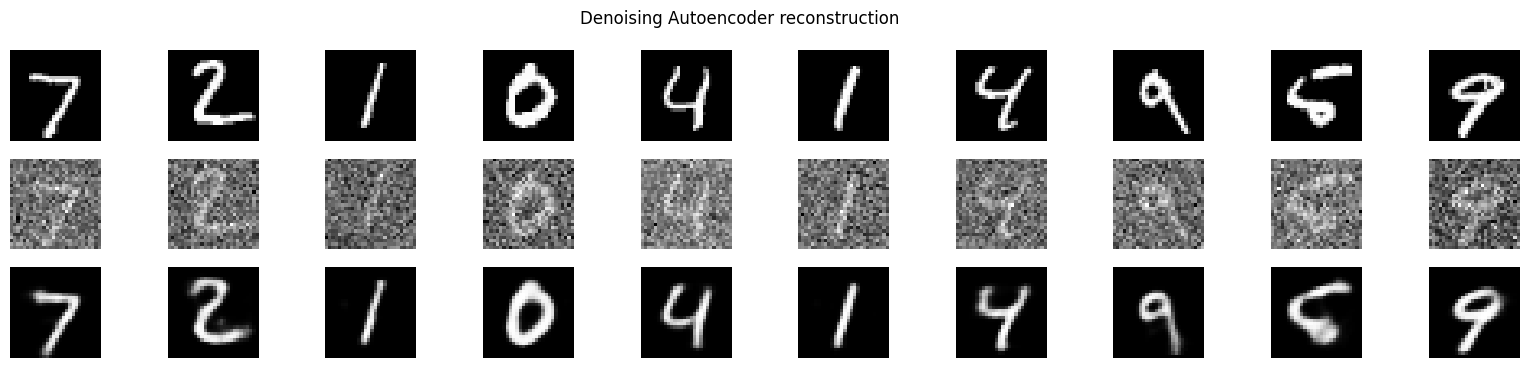

In [9]:
display_reconstructions(test_data,10,dae,"Denoising Autoencoder reconstruction")

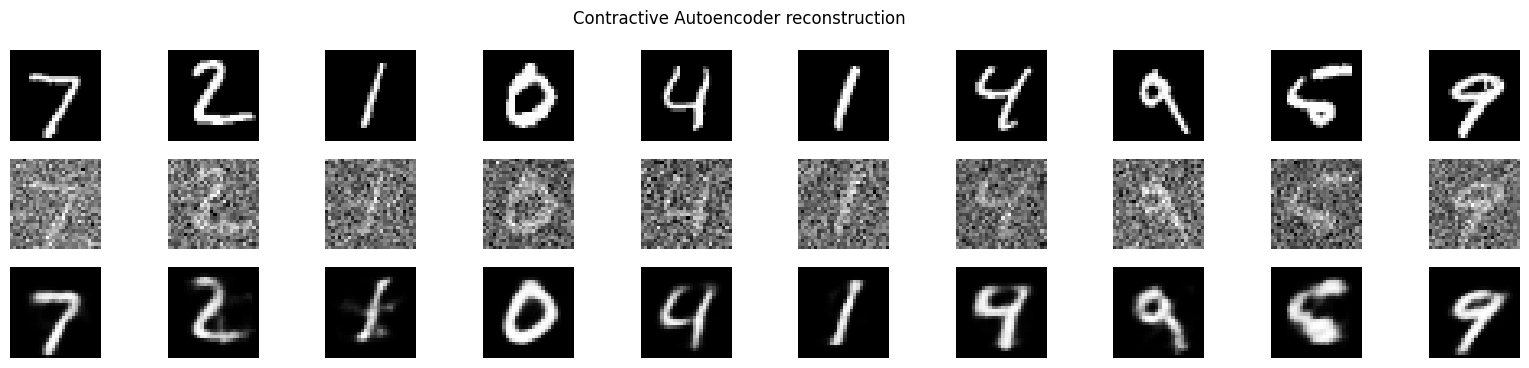

In [10]:
display_reconstructions(test_data,10,cae,"Contractive Autoencoder reconstruction")

As we can see the CAE manages to get sharper and more defined images while the CAE has mare shaded ones with some numbers not clearly formed or some deformations with some residual noise in the background.

## clasification accuracy
To get a better estimate of the quality of the learned representations from both encoders we can use their encoding part on a classification task on the same train-validation-test split, the better representation should perform better in this task.

First we define a function to fine tune the classifiers using the encoding blocks as initialization for the values.

In [11]:
from copy import deepcopy



def train_classifier(clf,train_data,val_data,n_epochs=10,learning_rate=0.001):
    """
    train classifier on data for n_epochs with a fixed learning rate
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr=learning_rate)
    for epoch in range(n_epochs):
        clf.train()
        train_loss = 0
        for sample in train_data:
            img, label = sample
            img = img.view(-1, 28*28)
            img=img.to(DEVICE)
            label=label.to(DEVICE)
            optimizer.zero_grad()
            output = clf(img)
            loss = criterion(output, label)
            train_loss += loss.item()*img.size(0)
            loss.backward()
            optimizer.step()
        clf.eval()
        val_loss = 0
        for sample in val_data:
            img, label = sample
            img = img.view(-1, 28*28)
            img=img.to(DEVICE)
            label=label.to(DEVICE)
            output = clf(img)
            loss = criterion(output, label)
            val_loss += loss.item()*img.size(0)
        val_loss = val_loss / len(val_data.dataset)
        train_loss = train_loss / len(train_data.dataset)
        print(f'epoch [{epoch + 1}/{n_epochs}], train loss:{train_loss}  validation loss:{val_loss}')

    


We define a function to compute the accuracy of the classifiers.

In [12]:
def compute_accuracy(clf,data):
    clf.eval()
    correct = 0
    with torch.no_grad():
        for sample in data:
            img, label = sample
            img = img.view(-1, 28*28)
            img=img.to(DEVICE)
            label=label.to(DEVICE)
            output = clf(img)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
    return correct / len(data.dataset)


Finally we define our classifiers using both encoders, then we can fine tune them and assess their capabilities over the test set.

In [13]:
CAE_clf=nn.Sequential(
    deepcopy(cae.encoder),
    nn.Linear(250,10),
    nn.Sigmoid()
).to(DEVICE)
DAE_clf=nn.Sequential(
    deepcopy(dae.encoder),
    nn.Linear(100,10),
    nn.Sigmoid()
).to(DEVICE)
print("training CAE classifier")
train_classifier(CAE_clf,train_loader,val_loader,20,0.001)
print("training DAE classifier")
train_classifier(DAE_clf,train_loader,val_loader,20,0.001)

print("CAE accuracy after fine tuning",compute_accuracy(CAE_clf,test_loader)*100)
print("DAE accuracy after fine tuning",compute_accuracy(DAE_clf,test_loader)*100)

training CAE classifier
epoch [1/20], train loss:1.6102614757919311  validation loss:1.5138487073898315
epoch [2/20], train loss:1.5349283806610108  validation loss:1.5009131660461426
epoch [3/20], train loss:1.5212478274536132  validation loss:1.4950648797988892
epoch [4/20], train loss:1.511950877761841  validation loss:1.4917349420547485
epoch [5/20], train loss:1.5069519440460204  validation loss:1.4895894603729247
epoch [6/20], train loss:1.5031467290115357  validation loss:1.4879527517318725
epoch [7/20], train loss:1.5010934812927246  validation loss:1.4870674909591675
epoch [8/20], train loss:1.4993364960098268  validation loss:1.4848662471771241
epoch [9/20], train loss:1.4964276015472413  validation loss:1.4836990295410157
epoch [10/20], train loss:1.4949263180160521  validation loss:1.4841942390441893
epoch [11/20], train loss:1.493170542640686  validation loss:1.4836693614959717
epoch [12/20], train loss:1.4937200259017944  validation loss:1.483364044380188
epoch [13/20], t

After fine tuning both models using the encoding part as intialization we can see that DAE manages to get a better result on the test by 0.5% over the CAE.

# Iterative gradient ascent


Now we can test the AE's capabilities of converging to the manifold from noise.
First we need to apply the gradient descent algorithm, to do so the output of an AE is feed to it as an input until we reach a maximum amount of possible iterations.

In [14]:
def apply_gradient_ascent(model, noise, num_iterations=1000):
    """
    reconstruct a digit by applying gradient ascent loss
    """
    #stop when the difference between two consecutive iterations is less than 1e-3 or when the maximum number of iterations is reached
    while(num_iterations>0):
        old_noise=noise
        _,noise = model(old_noise)
        num_iterations-=1
    reconstruction= noise.view(-1, 28*28)
    return reconstruction

## manifold convergence

Now we can analyze the convergence to the manifold, in order to do this we randomly generate a certain number of samples and plot the results of the gradient ascent algorithm for the contractive and denosing autoencoders.

To do so we use support function defined below.

In [15]:
def display_images(noise, ae,title):
    num_samples=noise.shape[0]
    plt.figure(figsize=(20, 4))
    for i in range(num_samples):
        # Display the reconstructed image
        plt.subplot(2, num_samples, i+1)
        plt.imshow(apply_gradient_ascent(ae, noise[i]).view(28, 28).detach().cpu().numpy(), cmap='gray',vmin=0, vmax=1)
        plt.axis('off')

        # Display the original image
        plt.subplot(2, num_samples, i+num_samples+1)
        plt.imshow(noise[i].view(28, 28).detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)


Now we can generate noise and display the result of the converge to the manifold.

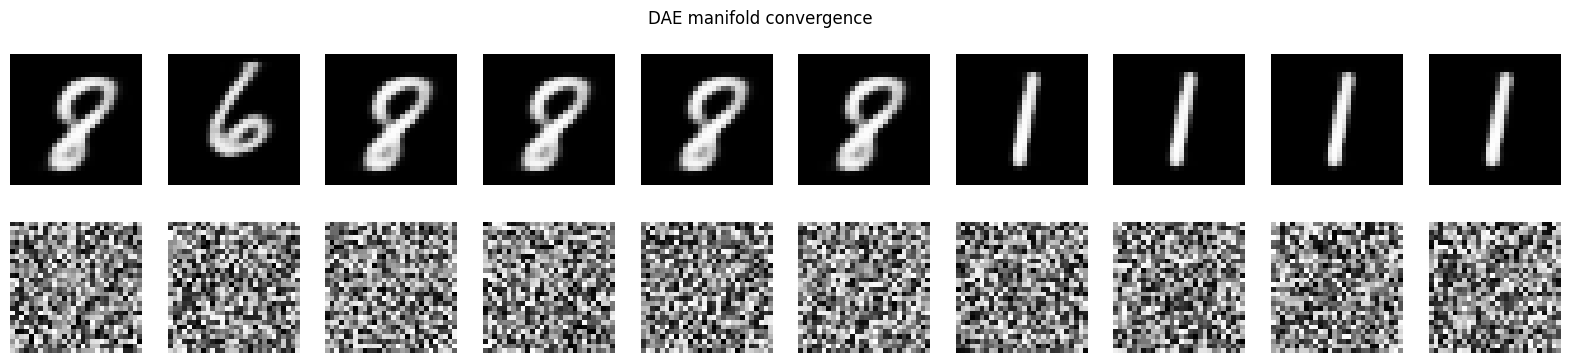

In [16]:
import matplotlib.pyplot as plt

num_samples=10
# used to get deterministic results, remove to generate new noise each time
#generate noise
noise=torch.rand(num_samples,28*28).requires_grad_(True).to(DEVICE)
display_images(noise,dae,"DAE manifold convergence")
pass

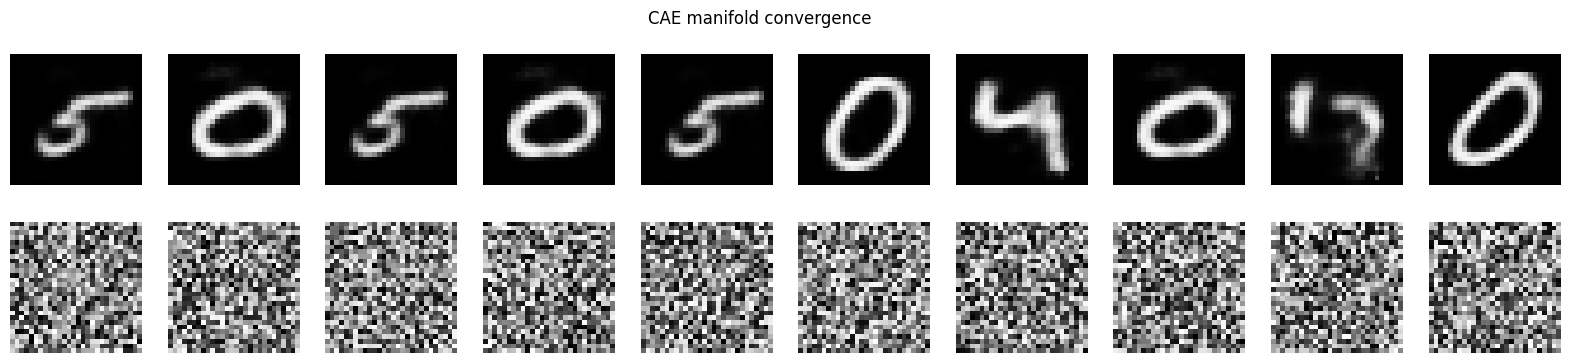

In [17]:
display_images(noise,cae,"CAE manifold convergence")
pass

So as we can see the DAE manages to get sharper and more defined digits while the CAE struggles a little and creates faded digits with some having blurred or deformed parts,overall both AE's manage to reach the manifold with some difficult for the CAE.

# Results

From the above experiments we can infer that the CAE performs worse with reconstrunction compared to the DAE, since the DAE learns to remove noise while CAE cares more about robust representation it makes sense that the DAE performs better on the reconstruction task as demonstrated by the reconstruction error on the test set.

For the manifold convergence the CAE still performs worse than the DAE and this happens also in the classification task, this could be due to the difference in the training and structure of both encoders in particular the CAE required a lot of attention during with its parameters,its structure and the use of dropout to get it to work properly.

This experiment shows the capabilities of the Autoencoders to learn feature representations from high dimensional spaces and demonstrates their usefulness and limitations in learning representations,in particular the CAE penalizes sentivity of ouput-input variations and the fact the we used an undercomplete AE suggests that the model preserves better important features in the input data.

Other interesting experiments could be using an overcomplete encoder and see its behavior, also a more complex structure and a model selection could benefit more the feature learning and reconstruction capabilities of both auto encoder types.

In general both encoders manage to reach the manifold and can reconstrunct correctly, with some difficulties for the CAE probably given by different structure and use of the dropout regularization